In [1]:
# load packages required for analysis
#install.packages("ranger")
#BiocManager::install("")

# load packages required for analysis
library(dplyr)
library(ggplot2)
library("minfi")
library("irlba")
library("RColorBrewer")
library("maptools")
library("scatterplot3d")

library(IlluminaHumanMethylationEPICmanifest)
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
library(wateRmelon)
library(repr)
library(GenomicRanges)
library(diffloop)
library(GeneOverlap)
library(clipr)
library("org.Hs.eg.db")
library("biomaRt")
library("GenomicFeatures")
library("BRGenomics")

library(randomForest)
library(mlbench)
library(caret)
library(ranger)

library(tidyverse)
library(splitstackshape)
library("pheatmap")

print("done loading packages")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading requir

[1] "done loading packages"


In [2]:
### import necessary variables
project_master_dir = "/stg3/data2/resource3/project/RA-TIP-CS"
#version_dir = "/YesSNPqc_Female_Allchrom"
version_dir = "/YesSNPqc_Female_Allchrom"

## input
analysis_object_fp = paste0(project_master_dir, "/Data/Processed_Data", "/02.gmSet_QCfiltered_All_dasen.RDS") # Female only, All Chrom, yes SNP QC filtering

# choose which loci to use
dml_output_dir = paste0(project_master_dir, "/Analysis", version_dir, "/DMLs")

selectedLoci_fp = paste0(dml_output_dir, "/dmlUnion_v1_all_F_allChrom_vector.csv")

rf_eravccpP_fp = paste0(dml_output_dir, "/rf_allCell_ccpPvera_dml_df.csv")
rf_eravccpM_fp = paste0(dml_output_dir, "/rf_allCell_ccpMvera_dml_df.csv")
rf_ccpPvccpM_fp = paste0(dml_output_dir, "/rf_allCell_ccpPvccpM_dml_df.csv")

## output
rfClass_output_dir = paste0(project_master_dir, "/Analysis", version_dir, "/rfClass")
dir.create(file.path(rfClass_output_dir), showWarnings = FALSE)

dataLog_fp = paste0(project_master_dir, "/Analysis", version_dir, "/dataLog.txt", append = TRUE)

In [3]:
### Perform Classification using Random Forest Model based on all post-QC loci and using only female samples
# define matrix
mSet_analysis_obj = readRDS(analysis_object_fp)
beta_analysis_df = getBeta(mSet_analysis_obj)
M_analysis_df = getM(mSet_analysis_obj)

# remove rows with NAs
keepIndex = apply(M_analysis_df,1,function(x){!any(is.na(x))})
M_analysis_df = M_analysis_df[keepIndex,]
beta_analysis_df = beta_analysis_df[keepIndex,]

# select only loci used in analysis
selectedLoci_vector = as.vector(read.csv(selectedLoci_fp)[,1, drop=TRUE])
M_analysis_df = M_analysis_df[selectedLoci_vector, ]
beta_analysis_df = beta_analysis_df[selectedLoci_vector, ]


In [4]:
## Setup each comparison dataframe
# ERA vs CCP+
eravccpP_loci_vector = rownames(read.csv(rf_eravccpP_fp, sep = "\t", row.names = 1))
eravccpP_samples_vector = grep(paste(c("ERA", "CCPpos"),collapse="|"), colnames(M_analysis_df), value = TRUE)
rf_eravccpP_M_analysis_df = M_analysis_df[eravccpP_loci_vector, eravccpP_samples_vector]

# ERA vs CCP-
eravccpM_loci_vector = rownames(read.csv(rf_eravccpM_fp, sep = "\t", row.names = 1))
eravccpM_samples_vector = grep(paste(c("ERA", "CCPneg"),collapse="|"), colnames(M_analysis_df), value = TRUE)
rf_eravccpM_M_analysis_df = M_analysis_df[eravccpM_loci_vector, eravccpM_samples_vector]

## CCP+ vs CCP-
ccpPvccpM_loci_vector = rownames(read.csv(rf_ccpPvccpM_fp, sep = "\t", row.names = 1))
ccpPvccpM_samples_vector = grep(paste(c("CCPpos", "CCPneg"),collapse="|"), colnames(M_analysis_df), value = TRUE)
rf_ccpPvccpM_M_analysis_df = M_analysis_df[ccpPvccpM_loci_vector, ccpPvccpM_samples_vector]

# all
all_loci_vector = Reduce(union, list(eravccpP_loci_vector,
                                     eravccpM_loci_vector,
                                     ccpPvccpM_loci_vector))
all_samples_vector = Reduce(union, list(eravccpP_samples_vector,
                                        eravccpM_samples_vector,
                                        ccpPvccpM_samples_vector))
rf_all_M_analysis_df = M_analysis_df[all_loci_vector, all_samples_vector]


[1] "Baseline model results:"
Random Forest 

161 samples
627 predictors
  2 classes: 'CCPpos', 'ERA' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 144, 145, 146, 145, 146, 144, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy   Kappa    
  0.8653758  0.6885823

Tuning parameter 'mtry' was held constant at a value of 26



Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 26

        OOB estimate of  error rate: 17.39%
Confusion matrix:
       CCPpos ERA class.error
CCPpos     39   7   0.1521739
ERA         9  37   0.1956522

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,26,0.8653758,0.6885823,0.08088645,0.1804752


[1] "Tuning results:"


[1] 26

[1] 2000

                Length Class      Mode     
call               5   -none-     call     
type               1   -none-     character
predicted         92   factor     numeric  
err.rate        6000   -none-     numeric  
confusion          6   -none-     numeric  
votes            184   matrix     numeric  
oob.times         92   -none-     numeric  
classes            2   -none-     character
importance       627   -none-     numeric  
importanceSD       0   -none-     NULL     
localImportance    0   -none-     NULL     
proximity          0   -none-     NULL     
ntree              1   -none-     numeric  
mtry               1   -none-     numeric  
forest            14   -none-     list     
y                 92   factor     numeric  
test               0   -none-     NULL     
inbag              0   -none-     NULL     
xNames           627   -none-     character
problemType        1   -none-     character
tuneValue          2   data.frame list     
obsLevels          2   -none-   

161 samples
627 predictors
  2 classes: 'CCPpos', 'ERA' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 145, 146, 144, 146, 145, 144, ... 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  mtry  ntree  Accuracy   Kappa    
  13    1000   0.8898938  0.7359602
  13    1500   0.8793546  0.7069382
  13    2000   0.8895261  0.7218837
  13    2500   0.8744036  0.6976168
  14    1000   0.8621324  0.6660331
  14    1500   0.8901389  0.7273690
  14    2000   0.8605229  0.6680477
  14    2500   0.8836601  0.7121183
  15    1000   0.8857108  0.7242109
  15    1500   0.9041258  0.7559773
  15    2000   0.8854984  0.7163710
  15    2500   0.8986275  0.7457458
  16    1000   0.8776225  0.6987023
  16    1500   0.8648775  0.6749110
  16    2000   0.8958987  0.7335952
  16    2500   0.8745425  0.6992871
  17    1000   0.9004657  0.7526843
  17    1500   0.8650163  0.6680591
  17    2000   0.8763480  0.7048357
 

[1] "Optimal model results:"
Random Forest 

161 samples
627 predictors
  2 classes: 'CCPpos', 'ERA' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 145, 145, 145, 144, 146, 145, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy   Kappa    
  0.8858987  0.7137875

Tuning parameter 'mtry' was held constant at a value of 26



Call:
 randomForest(x = x, y = y, ntree = ..1, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 26

        OOB estimate of  error rate: 11.96%
Confusion matrix:
       CCPpos ERA class.error
CCPpos     43   3  0.06521739
ERA         8  38  0.17391304

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,26,0.8858987,0.7137875,0.07293928,0.1796752


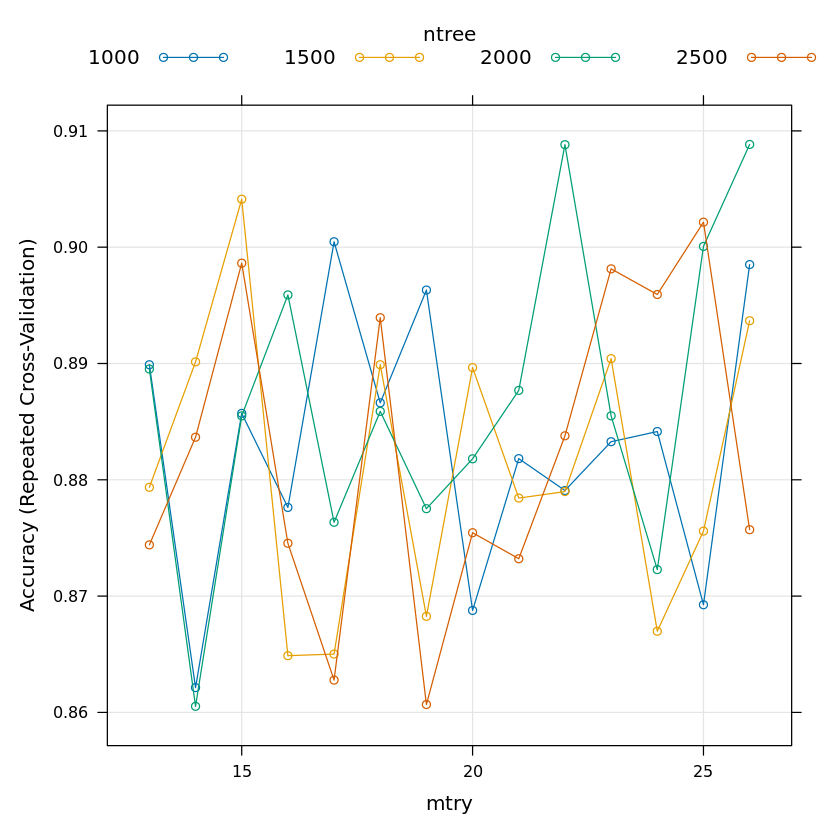

In [5]:
### Train Random Forest model

## Setup data for cross validation (10-fold)
# define which analysis
rf_analysis_df = rf_eravccpP_M_analysis_df

# Set seed for reproducibility, define df for analysis
set.seed(123)

# setup data for shuffling
rfFormatted_analysis_df = as.data.frame(t(rf_analysis_df))
RAstatus_vector = sapply(strsplit(rownames(rfFormatted_analysis_df), "_"), '[', 4)
rfFormatted_analysis_df['RA_Status'] = RAstatus_vector

# Split the data so that we use 70% of it for training
train_index = createDataPartition(y=rfFormatted_analysis_df$RA_Status, p=0.7, list=FALSE)

# Subset the data
training_set_df = rfFormatted_analysis_df[train_index, ]
testing_set_df = rfFormatted_analysis_df[-train_index, ]


## Train a baseline random forest model
# Define parameters
control = trainControl(method='repeatedcv', 
                       number=10, 
                       repeats=3, 
                       sampling = "down")
metric = "Accuracy"
mtry_upper = ceiling(sqrt(ncol(training_set_df)))
tunegrid = expand.grid(.mtry=mtry_upper)

# train model
rfClassModel_baseline = train(RA_Status~.,
                              data=training_set_df,
                              method='rf',
                              trControl=control,
                              metric=metric,
                              tuneGrid=tunegrid)                                      

# Print out the details about the baseline model
print("Baseline model results:")
print(rfClassModel_baseline)
rfClassModel_baseline$finalModel
rfClassModel_baseline$results


## Tune Random Forest model
# customization taken from https://machinelearningmastery.com/tune-machine-learning-algorithms-in-r/
customRF <- list(type = "Classification", library = "randomForest", loop = NULL)
customRF$parameters <- data.frame(parameter = c("mtry", "ntree"), class = rep("numeric", 2), label = c("mtry", "ntree"))
customRF$grid <- function(x, y, len = NULL, search = "grid") {}
customRF$fit <- function(x, y, wts, param, lev, last, weights, classProbs, ...) {
  randomForest(x, y, mtry = param$mtry, ntree=param$ntree, ...)
}
customRF$predict <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata)
customRF$prob <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata, type = "prob")
customRF$sort <- function(x) x[order(x[,1]),]
customRF$levels <- function(x) x$classes

# set expanded parameters
control = trainControl(method="repeatedcv", 
                       number=10, 
                       repeats=3,
                       sampling = "down")
mtry_upper = ceiling(sqrt(ncol(training_set_df)))
mtry_lower = ceiling(0.5*mtry_upper)
metric = "Accuracy"
tunegrid = expand.grid(.mtry=c(mtry_lower:mtry_upper), .ntree=c(1000, 1500, 2000, 2500))

# tune and train model
rfClassModel_tune = train(RA_Status~.,
                          data=training_set_df,
                          method=customRF, 
                          metric=metric, 
                          tuneGrid=tunegrid, 
                          trControl=control)

# print out the tuning results
print("Tuning results:")
mtry_best = rfClassModel_tune$bestTune[1,1]
ntree_best = rfClassModel_tune$bestTune[1,2]
mtry_best
ntree_best
summary(rfClassModel_tune)
plot(rfClassModel_tune)
rfClassModel_tune


## Create optimal Random Forest model
# Define parameters
control = trainControl(method='repeatedcv', 
                       number=10, 
                       repeats=3, 
                       sampling = "down")
metric = "Accuracy"
tunegrid = expand.grid(.mtry=mtry_best)

# train model
rfClassModel_eravccpP_optMod = train(RA_Status~.,
                              data=training_set_df,
                              method='rf',
                              trControl=control,
                              metric=metric,
                              ntree = ntree_best,
                              tuneGrid=tunegrid)                                      

# Print out the details about the baseline model
print("Optimal model results:")
print(rfClassModel_eravccpP_optMod)
rfClassModel_eravccpP_optMod$finalModel
rfClassModel_eravccpP_optMod$results

# store test dataset
eravccpP_testing_set_df = testing_set_df


[1] "Baseline model results:"
Random Forest 

 153 samples
1221 predictors
   2 classes: 'CCPneg', 'ERA' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 138, 138, 138, 138, 137, 138, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy   Kappa    
  0.8527183  0.6673896

Tuning parameter 'mtry' was held constant at a value of 35



Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 35

        OOB estimate of  error rate: 19.57%
Confusion matrix:
       CCPneg ERA class.error
CCPneg     38   8   0.1739130
ERA        10  36   0.2173913

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,0.8527183,0.6673896,0.08719076,0.1877072


[1] "Tuning results:"


[1] 31

[1] 2500

                Length Class      Mode     
call               5   -none-     call     
type               1   -none-     character
predicted         92   factor     numeric  
err.rate        7500   -none-     numeric  
confusion          6   -none-     numeric  
votes            184   matrix     numeric  
oob.times         92   -none-     numeric  
classes            2   -none-     character
importance      1221   -none-     numeric  
importanceSD       0   -none-     NULL     
localImportance    0   -none-     NULL     
proximity          0   -none-     NULL     
ntree              1   -none-     numeric  
mtry               1   -none-     numeric  
forest            14   -none-     list     
y                 92   factor     numeric  
test               0   -none-     NULL     
inbag              0   -none-     NULL     
xNames          1221   -none-     character
problemType        1   -none-     character
tuneValue          2   data.frame list     
obsLevels          2   -none-   

 153 samples
1221 predictors
   2 classes: 'CCPneg', 'ERA' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 139, 137, 138, 137, 137, 138, ... 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  mtry  ntree  Accuracy   Kappa    
  18    1000   0.7918452  0.5469151
  18    1500   0.8004365  0.5545645
  18    2000   0.8095040  0.5705322
  18    2500   0.8072421  0.5700103
  19    1000   0.8011706  0.5610136
  19    1500   0.8013294  0.5576836
  19    2000   0.7820040  0.5132713
  19    2500   0.7993651  0.5447143
  20    1000   0.7941865  0.5402957
  20    1500   0.8168849  0.5886473
  20    2000   0.7783532  0.5098573
  20    2500   0.8122817  0.5849903
  21    1000   0.8032540  0.5645939
  21    1500   0.8060516  0.5682614
  21    2000   0.8103770  0.5739356
  21    2500   0.8159127  0.5828644
  22    1000   0.7996825  0.5524301
  22    1500   0.8055357  0.5731414
  22    2000   0.8011905  0.551752

[1] "Optimal model results:"
Random Forest 

 153 samples
1221 predictors
   2 classes: 'CCPneg', 'ERA' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 137, 139, 139, 138, 137, 138, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy   Kappa    
  0.8296032  0.6252095

Tuning parameter 'mtry' was held constant at a value of 31



Call:
 randomForest(x = x, y = y, ntree = ..1, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 2500
No. of variables tried at each split: 31

        OOB estimate of  error rate: 22.83%
Confusion matrix:
       CCPneg ERA class.error
CCPneg     34  12   0.2608696
ERA         9  37   0.1956522

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,31,0.8296032,0.6252095,0.1251859,0.2582864


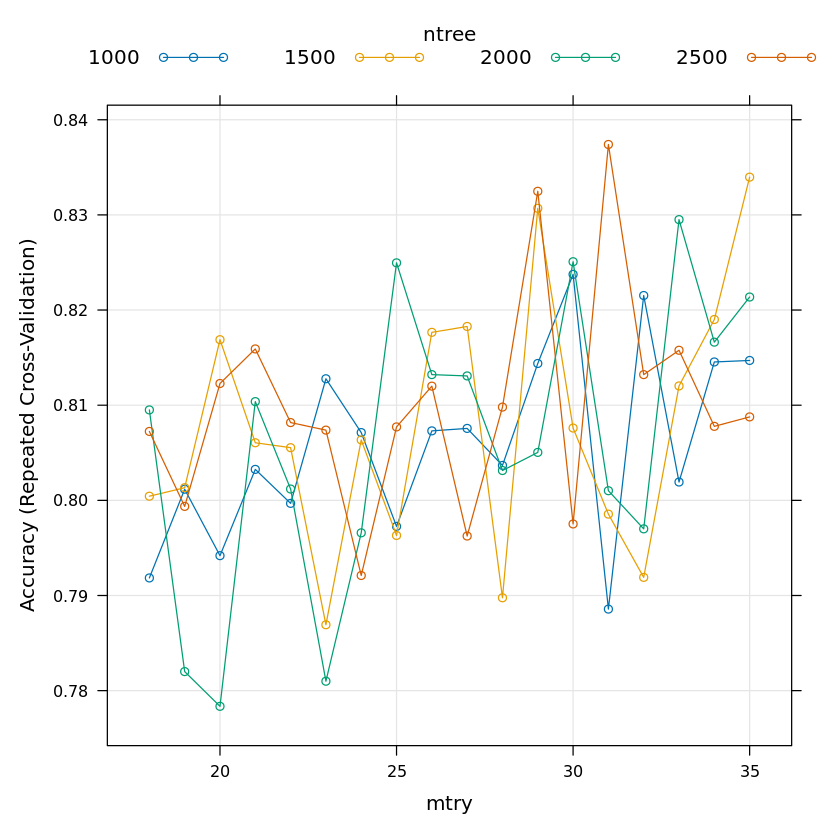

In [6]:
### Train Random Forest model

## Setup data for cross validation (10-fold)
# define which analysis
rf_analysis_df = rf_eravccpM_M_analysis_df

# Set seed for reproducibility, define df for analysis
set.seed(123)

# setup data for shuffling
rfFormatted_analysis_df = as.data.frame(t(rf_analysis_df))
RAstatus_vector = sapply(strsplit(rownames(rfFormatted_analysis_df), "_"), '[', 4)
rfFormatted_analysis_df['RA_Status'] = RAstatus_vector

# Split the data so that we use 70% of it for training
train_index = createDataPartition(y=rfFormatted_analysis_df$RA_Status, p=0.7, list=FALSE)

# Subset the data
training_set_df = rfFormatted_analysis_df[train_index, ]
testing_set_df = rfFormatted_analysis_df[-train_index, ]


## Train a baseline random forest model
# Define parameters
control = trainControl(method='repeatedcv', 
                       number=10, 
                       repeats=3, 
                       sampling = "down")
metric = "Accuracy"
mtry_upper = ceiling(sqrt(ncol(training_set_df)))
tunegrid = expand.grid(.mtry=mtry_upper)

# train model
rfClassModel_baseline = train(RA_Status~.,
                              data=training_set_df,
                              method='rf',
                              trControl=control,
                              metric=metric,
                              tuneGrid=tunegrid)                                      

# Print out the details about the baseline model
print("Baseline model results:")
print(rfClassModel_baseline)
rfClassModel_baseline$finalModel
rfClassModel_baseline$results


## Tune Random Forest model
customRF <- list(type = "Classification", library = "randomForest", loop = NULL)
customRF$parameters <- data.frame(parameter = c("mtry", "ntree"), class = rep("numeric", 2), label = c("mtry", "ntree"))
customRF$grid <- function(x, y, len = NULL, search = "grid") {}
customRF$fit <- function(x, y, wts, param, lev, last, weights, classProbs, ...) {
  randomForest(x, y, mtry = param$mtry, ntree=param$ntree, ...)
}
customRF$predict <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata)
customRF$prob <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata, type = "prob")
customRF$sort <- function(x) x[order(x[,1]),]
customRF$levels <- function(x) x$classes

# set expanded parameters
control = trainControl(method="repeatedcv", 
                       number=10, 
                       repeats=3,
                       sampling = "down")
mtry_upper = ceiling(sqrt(ncol(training_set_df)))
mtry_lower = ceiling(0.5*mtry_upper)
metric = "Accuracy"
tunegrid = expand.grid(.mtry=c(mtry_lower:mtry_upper), .ntree=c(1000, 1500, 2000, 2500))

# tune and train model
rfClassModel_tune = train(RA_Status~.,
                          data=training_set_df,
                          method=customRF, 
                          metric=metric, 
                          tuneGrid=tunegrid, 
                          trControl=control)

# print out the tuning results
print("Tuning results:")
mtry_best = rfClassModel_tune$bestTune[1,1]
ntree_best = rfClassModel_tune$bestTune[1,2]
mtry_best
ntree_best
summary(rfClassModel_tune)
plot(rfClassModel_tune)
rfClassModel_tune


## Create optimal Random Forest model
# Define parameters
control = trainControl(method='repeatedcv', 
                       number=10, 
                       repeats=3, 
                       sampling = "down")
metric = "Accuracy"
tunegrid = expand.grid(.mtry=mtry_best)

# train model
rfClassModel_eravccpM_optMod = train(RA_Status~.,
                              data=training_set_df,
                              method='rf',
                              trControl=control,
                              metric=metric,
                              ntree = ntree_best,
                              tuneGrid=tunegrid)                                      

# Print out the details about the baseline model
print("Optimal model results:")
print(rfClassModel_eravccpM_optMod)
rfClassModel_eravccpM_optMod$finalModel
rfClassModel_eravccpM_optMod$results

# store test dataset
eravccpM_testing_set_df = testing_set_df

[1] "Baseline model results:"
Random Forest 

222 samples
136 predictors
  2 classes: 'CCPneg', 'CCPpos' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 199, 200, 199, 200, 200, 200, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy   Kappa    
  0.8947519  0.7888608

Tuning parameter 'mtry' was held constant at a value of 12



Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 12

        OOB estimate of  error rate: 9.81%
Confusion matrix:
       CCPneg CCPpos class.error
CCPneg     96     11  0.10280374
CCPpos     10     97  0.09345794

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12,0.8947519,0.7888608,0.06645288,0.1333165


[1] "Tuning results:"


[1] 7

[1] 1500

                Length Class      Mode     
call               5   -none-     call     
type               1   -none-     character
predicted        214   factor     numeric  
err.rate        4500   -none-     numeric  
confusion          6   -none-     numeric  
votes            428   matrix     numeric  
oob.times        214   -none-     numeric  
classes            2   -none-     character
importance       136   -none-     numeric  
importanceSD       0   -none-     NULL     
localImportance    0   -none-     NULL     
proximity          0   -none-     NULL     
ntree              1   -none-     numeric  
mtry               1   -none-     numeric  
forest            14   -none-     list     
y                214   factor     numeric  
test               0   -none-     NULL     
inbag              0   -none-     NULL     
xNames           136   -none-     character
problemType        1   -none-     character
tuneValue          2   data.frame list     
obsLevels          2   -none-   

222 samples
136 predictors
  2 classes: 'CCPneg', 'CCPpos' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 200, 200, 200, 201, 199, 199, ... 
Addtional sampling using down-sampling

Resampling results across tuning parameters:

  mtry  ntree  Accuracy   Kappa    
   6    1000   0.8984817  0.7968150
   6    1500   0.8986982  0.7973101
   6    2000   0.8913796  0.7823502
   6    2500   0.8969666  0.7938145
   7    1000   0.8938578  0.7872363
   7    1500   0.9042725  0.8084753
   7    2000   0.8882772  0.7763167
   7    2500   0.8954514  0.7906432
   8    1000   0.8907617  0.7810596
   8    1500   0.8952475  0.7901235
   8    2000   0.8957871  0.7911832
   8    2500   0.8851622  0.7702367
   9    1000   0.8955173  0.7907582
   9    1500   0.8895226  0.7785854
   9    2000   0.8883493  0.7763559
   9    2500   0.8967564  0.7928748
  10    1000   0.8938641  0.7875225
  10    1500   0.8880733  0.7756898
  10    2000   0.8972426  0.794377

[1] "Optimal model results:"
Random Forest 

222 samples
136 predictors
  2 classes: 'CCPneg', 'CCPpos' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 200, 201, 200, 201, 199, 199, ... 
Addtional sampling using down-sampling

Resampling results:

  Accuracy  Kappa    
  0.892923  0.7856277

Tuning parameter 'mtry' was held constant at a value of 7



Call:
 randomForest(x = x, y = y, ntree = ..1, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 1500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 8.88%
Confusion matrix:
       CCPneg CCPpos class.error
CCPneg     98      9  0.08411215
CCPpos     10     97  0.09345794

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,0.892923,0.7856277,0.06728215,0.1344497


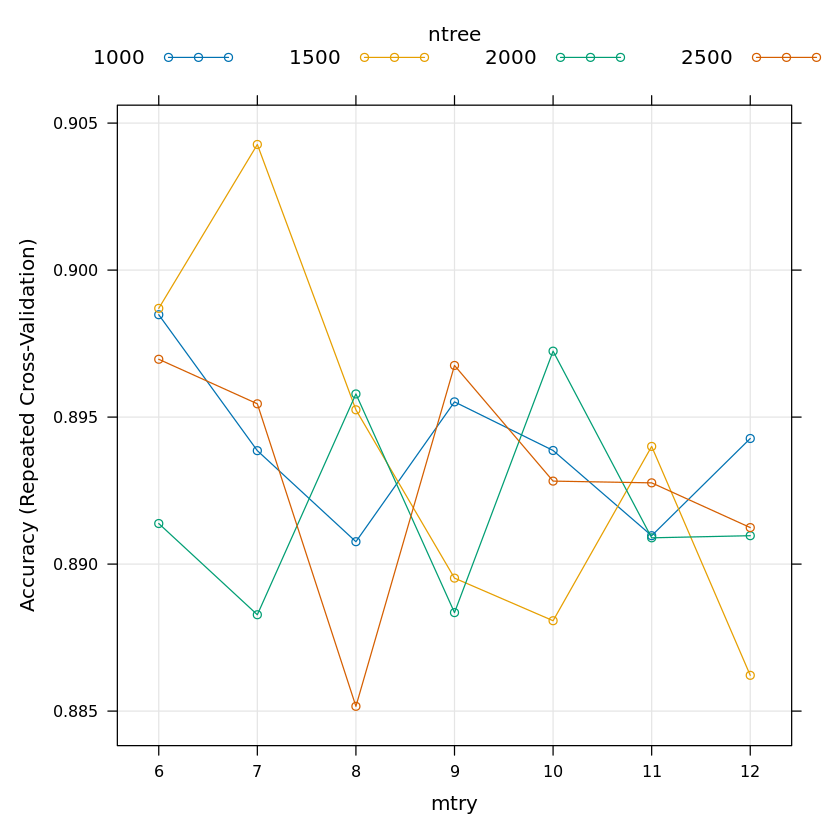

In [7]:
### Train Random Forest model

## Setup data for cross validation (10-fold)
# define which analysis
rf_analysis_df = rf_ccpPvccpM_M_analysis_df

# Set seed for reproducibility, define df for analysis
set.seed(123)

# setup data for shuffling
rfFormatted_analysis_df = as.data.frame(t(rf_analysis_df))
RAstatus_vector = sapply(strsplit(rownames(rfFormatted_analysis_df), "_"), '[', 4)
rfFormatted_analysis_df['RA_Status'] = RAstatus_vector

# Split the data so that we use 70% of it for training
train_index = createDataPartition(y=rfFormatted_analysis_df$RA_Status, p=0.7, list=FALSE)

# Subset the data
training_set_df = rfFormatted_analysis_df[train_index, ]
testing_set_df = rfFormatted_analysis_df[-train_index, ]


## Train a baseline random forest model
# Define parameters
control = trainControl(method='repeatedcv', 
                       number=10, 
                       repeats=3, 
                       sampling = "down")
metric = "Accuracy"
mtry_upper = ceiling(sqrt(ncol(training_set_df)))
tunegrid = expand.grid(.mtry=mtry_upper)

# train model
rfClassModel_baseline = train(RA_Status~.,
                              data=training_set_df,
                              method='rf',
                              trControl=control,
                              metric=metric,
                              tuneGrid=tunegrid)                                      

# Print out the details about the baseline model
print("Baseline model results:")
print(rfClassModel_baseline)
rfClassModel_baseline$finalModel
rfClassModel_baseline$results


## Tune Random Forest model
customRF <- list(type = "Classification", library = "randomForest", loop = NULL)
customRF$parameters <- data.frame(parameter = c("mtry", "ntree"), class = rep("numeric", 2), label = c("mtry", "ntree"))
customRF$grid <- function(x, y, len = NULL, search = "grid") {}
customRF$fit <- function(x, y, wts, param, lev, last, weights, classProbs, ...) {
  randomForest(x, y, mtry = param$mtry, ntree=param$ntree, ...)
}
customRF$predict <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata)
customRF$prob <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
   predict(modelFit, newdata, type = "prob")
customRF$sort <- function(x) x[order(x[,1]),]
customRF$levels <- function(x) x$classes

# set expanded parameters
control = trainControl(method="repeatedcv", 
                       number=10, 
                       repeats=3,
                       sampling = "down")
mtry_upper = ceiling(sqrt(ncol(training_set_df)))
mtry_lower = ceiling(0.5*mtry_upper)
metric = "Accuracy"
tunegrid = expand.grid(.mtry=c(mtry_lower:mtry_upper), .ntree=c(1000, 1500, 2000, 2500))

# tune and train model
rfClassModel_tune = train(RA_Status~.,
                          data=training_set_df,
                          method=customRF, 
                          metric=metric, 
                          tuneGrid=tunegrid, 
                          trControl=control)

# print out the tuning results
print("Tuning results:")
mtry_best = rfClassModel_tune$bestTune[1,1]
ntree_best = rfClassModel_tune$bestTune[1,2]
mtry_best
ntree_best
summary(rfClassModel_tune)
plot(rfClassModel_tune)
rfClassModel_tune


## Create optimal Random Forest model
# Define parameters
control = trainControl(method='repeatedcv', 
                       number=10, 
                       repeats=3, 
                       sampling = "down")
metric = "Accuracy"
tunegrid = expand.grid(.mtry=mtry_best)

# train model
rfClassModel_ccpPvccpM_optMod = train(RA_Status~.,
                              data=training_set_df,
                              method='rf',
                              trControl=control,
                              metric=metric,
                              ntree = ntree_best,
                              tuneGrid=tunegrid)                                      

# Print out the details about the baseline model
print("Optimal model results:")
print(rfClassModel_ccpPvccpM_optMod)
rfClassModel_ccpPvccpM_optMod$finalModel
rfClassModel_ccpPvccpM_optMod$results

# store test dataset
ccpPvccpM_testing_set_df = testing_set_df

In [8]:
### Test models
## ERA vs CCP+
# Generate predictions
eravccpP_y_hats = predict(object=rfClassModel_eravccpP_optMod,                                                     # Random forest object
                 newdata=subset(eravccpP_testing_set_df, select = -c(RA_Status)))                  # Data to use for predictions; remove RA_Status

# output results
eravccpP_accuracy = mean(eravccpP_y_hats == eravccpP_testing_set_df$RA_Status)*100
print(eravccpP_accuracy)

## ERA vs CCP-
# Generate predictions
eravccpM_y_hats = predict(object=rfClassModel_eravccpM_optMod,                                                     # Random forest object
                 newdata=subset(eravccpM_testing_set_df, select = -c(RA_Status)))                  # Data to use for predictions; remove RA_Status

# output results
eravccpM_accuracy = mean(eravccpM_y_hats == eravccpM_testing_set_df$RA_Status)*100
print(eravccpM_accuracy)

## CCP+ vs CCP-

# Generate predictions
ccpPvccpM_y_hats = predict(object=rfClassModel_ccpPvccpM_optMod,                                                     # Random forest object
                 newdata=subset(ccpPvccpM_testing_set_df, select = -c(RA_Status)))                  # Data to use for predictions; remove RA_Status

# output results
ccpPvccpM_accuracy = mean(ccpPvccpM_y_hats == ccpPvccpM_testing_set_df$RA_Status)*100
print(ccpPvccpM_accuracy)



[1] 89.70588
[1] 78.125
[1] 96.80851


[1] "ERA vs CCP+"


,p41_ls39_B_CCPpos,p38_ls29_B_CCPneg,p11_ls4_B_CCPneg,p60_ls53_B_ERA,p24_ls27_B_CCPneg,p4_ls9_B_CCPpos,p65_ls66_B_CCPneg,p54_ls71_B_CCPneg,p42_ls36_B_CCPpos,p18_ls19_B_CCPneg,⋯,p109_ls109_Tmem_ERA,p66_ls57_Tnai_CCPpos,p125_ls124_Tnai_ERA,p75_ls75_B_CCPneg,p28_ls21_Tnai_CCPneg,p83_ls89_Tnai_CCPpos,p93_ls92_B_CCPpos,p119_ls119_Tnai_CCPpos,p119_ls119_Tmem_CCPpos,p119_ls119_B_CCPpos
cg02063695,0.7801808,-0.201838583,-0.19495530,-1.2442024,0.38272640,0.39801810,0.1611677,0.24624655,-0.7731430,-2.06445872,⋯,0.706471730,0.04171280,0.17165502,-0.12490942,-0.2254048,-0.1546066,0.02321129,-0.13247040,0.03545509,0.08098243
cg05084668,-0.2077077,-0.233097168,1.93619294,1.8811427,2.36323424,-0.15626478,2.1858616,-0.20839212,1.6744791,1.93771978,⋯,2.113473511,-0.46614689,1.55400497,2.15646037,1.0943135,-0.5665193,2.19229924,1.70231561,1.82606289,2.26009221
cg23159337,0.2747343,0.009739944,0.06218737,0.4369675,0.03512952,0.54295873,0.5522265,-0.01543217,0.3242279,1.23665626,⋯,0.522878852,0.29687472,0.08358002,-0.67646459,-1.1528715,-0.4798483,0.68990460,-0.03927650,0.02793846,0.15553945
cg14137381,0.1922052,0.645010799,0.68592439,-0.7606900,0.03580573,0.05819223,0.3443150,-0.28954154,-0.4121392,0.35117069,⋯,0.006717197,-0.42586374,1.01213070,0.68511570,0.7268096,-0.1067666,-0.12009038,-0.02317521,-0.18045967,-0.32470561
cg22025206,-0.1678833,-0.067808102,0.18675601,-1.3664297,-0.13755160,-0.48069861,-0.1393007,-1.17909668,-1.0665027,-0.44373409,⋯,-0.817773412,-1.55512144,-0.49129636,0.07049532,-0.5300890,-1.3204876,-0.45767427,-1.37580756,-1.00503092,-1.42682904
cg11629812,-0.7013500,1.152034092,1.04964868,0.7139686,-0.11916730,0.20038075,-0.7887001,0.60279905,0.2458814,0.06676049,⋯,0.166493762,0.05803599,-0.10730352,0.27355853,0.9603154,0.6041320,0.20201377,-0.39467029,-0.61323704,-0.54097344


[1]  63 381

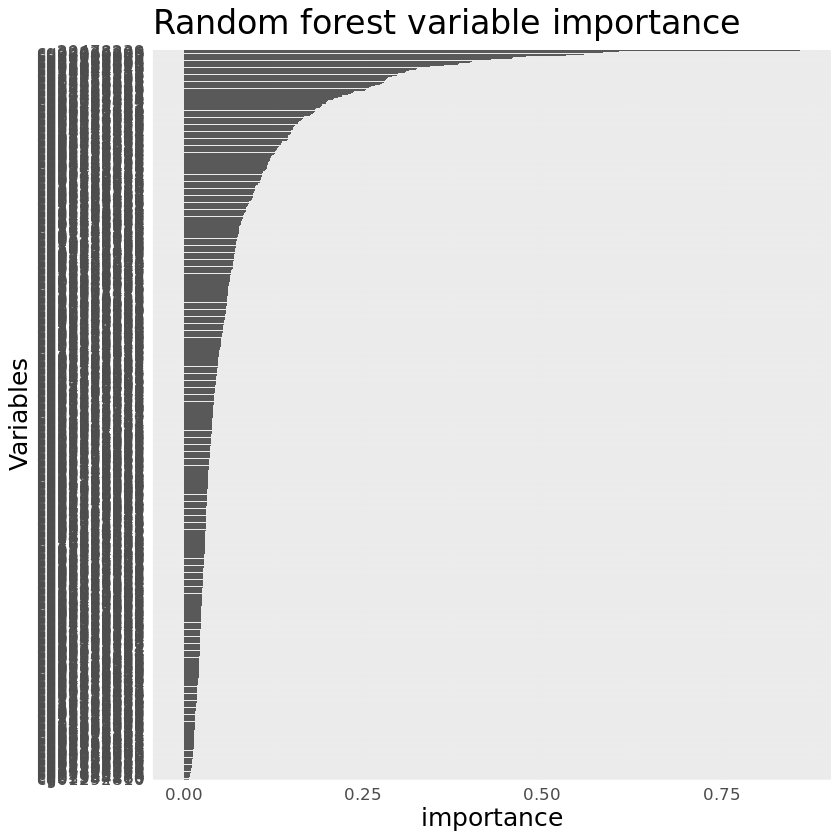

[1] "ERA vs CCP-"


,p41_ls39_B_CCPpos,p38_ls29_B_CCPneg,p11_ls4_B_CCPneg,p60_ls53_B_ERA,p24_ls27_B_CCPneg,p4_ls9_B_CCPpos,p65_ls66_B_CCPneg,p54_ls71_B_CCPneg,p42_ls36_B_CCPpos,p18_ls19_B_CCPneg,⋯,p109_ls109_Tmem_ERA,p66_ls57_Tnai_CCPpos,p125_ls124_Tnai_ERA,p75_ls75_B_CCPneg,p28_ls21_Tnai_CCPneg,p83_ls89_Tnai_CCPpos,p93_ls92_B_CCPpos,p119_ls119_Tnai_CCPpos,p119_ls119_Tmem_CCPpos,p119_ls119_B_CCPpos
cg13546858,-0.05276026,-0.1009105,-0.4478237,1.0896613,-1.460962705,-0.1381888,-0.5774148,-0.2674984,0.1554311,-0.03806618,⋯,1.0564262,-1.1194971,-0.7185300,1.19335946,-0.90220883,-0.006752168,0.47557493,-0.8679379,-0.66062173,-0.65393407
cg02063695,0.78018077,-0.2018386,-0.1949553,-1.2442024,0.382726398,0.3980181,0.1611677,0.2462465,-0.7731430,-2.06445872,⋯,0.7064717,0.0417128,0.1716550,-0.12490942,-0.22540476,-0.154606584,0.02321129,-0.1324704,0.03545509,0.08098243
cg02769477,0.91535354,0.2280216,-0.2358347,-0.8648271,-0.002389502,0.2188094,-0.1118097,0.7052959,-0.3424331,-2.87204664,⋯,1.4809540,1.4194342,1.9965205,0.06034411,1.39495748,1.482709489,0.37960320,1.0171505,0.64629093,0.73970811
cg10417901,-0.88208017,-0.4487960,-0.7960828,0.1482680,-0.397674853,-0.8378589,-0.2080845,-0.8877385,-0.5483143,-0.86639438,⋯,-1.0426165,-0.2691439,-0.4702694,-0.48723312,-0.26292231,-0.651616834,-0.33310641,-0.5447357,-0.59311352,-0.47211937
cg07929412,0.13796230,2.0152944,2.2692059,0.1958413,2.112926214,-3.0265838,2.1179184,2.3515078,1.9822489,2.49387187,⋯,0.2322377,0.1942126,2.4284819,1.98551230,-0.20209004,1.961411397,-3.03716929,-0.4536956,0.49806334,0.49971778
cg24229304,0.44364951,0.5053171,-0.3114890,1.2194014,-0.578970998,-0.6636804,-0.6173853,0.5483823,1.1827764,-0.75357731,⋯,-0.7513955,-0.4408662,0.2627605,0.19833186,0.04291198,-0.838265486,0.53361819,-0.9061331,-0.99154767,-0.03823639


[1] 122 381

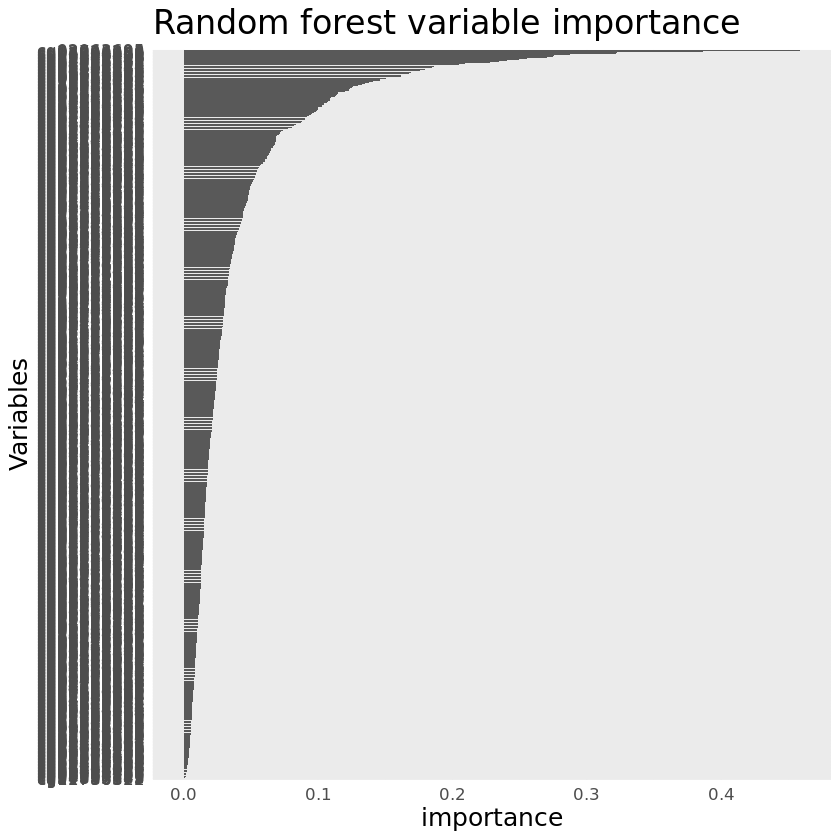

[1] "CCP+ vs CCP-"


,p41_ls39_B_CCPpos,p38_ls29_B_CCPneg,p11_ls4_B_CCPneg,p60_ls53_B_ERA,p24_ls27_B_CCPneg,p4_ls9_B_CCPpos,p65_ls66_B_CCPneg,p54_ls71_B_CCPneg,p42_ls36_B_CCPpos,p18_ls19_B_CCPneg,⋯,p109_ls109_Tmem_ERA,p66_ls57_Tnai_CCPpos,p125_ls124_Tnai_ERA,p75_ls75_B_CCPneg,p28_ls21_Tnai_CCPneg,p83_ls89_Tnai_CCPpos,p93_ls92_B_CCPpos,p119_ls119_Tnai_CCPpos,p119_ls119_Tmem_CCPpos,p119_ls119_B_CCPpos
cg17035899,-3.1828063,-3.56046492,-2.2693166,-1.6408729,-3.563411,-3.09712576,-3.9075874,-3.26793145,-0.006826042,-2.7675840,⋯,-3.4395942,-3.0795333,-2.7765668,-1.7335825,-2.7655222,-2.8372657,-2.9461460,-2.62385211,-2.3415381,-3.07223648
cg19287610,-0.1759903,1.06393033,0.3937387,1.0461395,1.081194,0.02226027,1.2881532,1.74480025,0.845438870,0.8185154,⋯,1.3238855,1.5162482,1.8814493,0.4539328,-0.5130747,0.3905826,0.9445713,0.71299984,0.3621442,0.56623949
cg22785556,-1.0419806,2.91875022,0.3932234,2.0563056,2.921261,3.16854560,2.9211796,2.87345409,3.011310160,2.8924949,⋯,-0.1607812,2.9084453,3.1159958,3.2006953,3.1510864,2.4534843,-0.3083759,2.68791389,2.7558875,2.70664022
cg07965995,-1.8126746,-0.22640663,-0.1888222,-0.3457732,1.939018,-2.00718663,1.6563874,-0.30473344,-0.217184367,1.6023355,⋯,-0.3806796,1.4911435,-0.5888401,-1.9095589,1.4713324,-1.9200410,1.3955446,-0.28549932,-0.2144263,-0.17975457
cg08103988,-2.1143113,0.45824242,0.2929831,-1.9194597,2.880187,-1.54209777,0.6214433,0.22192928,-2.319586657,3.2650334,⋯,3.6605695,-0.4674730,-0.1130378,3.0717483,-2.6929891,3.5101081,-2.4439620,-0.08367199,-0.1499055,-0.05808763
cg21358336,-2.0134493,0.08660057,0.5278190,-1.9587473,1.955434,-1.95381914,0.2232938,0.02850702,-2.665315792,3.1681680,⋯,2.7998506,-0.4810027,-0.2406988,2.4955913,-2.7257510,1.9083878,-2.0445593,0.01599056,0.3817954,0.07430494


[1]  14 381

[1] "combined data"


,p41_ls39_B_CCPpos,p38_ls29_B_CCPneg,p11_ls4_B_CCPneg,p60_ls53_B_ERA,p24_ls27_B_CCPneg,p4_ls9_B_CCPpos,p65_ls66_B_CCPneg,p54_ls71_B_CCPneg,p42_ls36_B_CCPpos,p18_ls19_B_CCPneg,⋯,p109_ls109_Tmem_ERA,p66_ls57_Tnai_CCPpos,p125_ls124_Tnai_ERA,p75_ls75_B_CCPneg,p28_ls21_Tnai_CCPneg,p83_ls89_Tnai_CCPpos,p93_ls92_B_CCPpos,p119_ls119_Tnai_CCPpos,p119_ls119_Tmem_CCPpos,p119_ls119_B_CCPpos
cg02063695,0.7801808,-0.201838583,-0.19495530,-1.2442024,0.38272640,0.39801810,0.1611677,0.24624655,-0.7731430,-2.06445872,⋯,0.706471730,0.04171280,0.17165502,-0.12490942,-0.2254048,-0.1546066,0.02321129,-0.13247040,0.03545509,0.08098243
cg05084668,-0.2077077,-0.233097168,1.93619294,1.8811427,2.36323424,-0.15626478,2.1858616,-0.20839212,1.6744791,1.93771978,⋯,2.113473511,-0.46614689,1.55400497,2.15646037,1.0943135,-0.5665193,2.19229924,1.70231561,1.82606289,2.26009221
cg23159337,0.2747343,0.009739944,0.06218737,0.4369675,0.03512952,0.54295873,0.5522265,-0.01543217,0.3242279,1.23665626,⋯,0.522878852,0.29687472,0.08358002,-0.67646459,-1.1528715,-0.4798483,0.68990460,-0.03927650,0.02793846,0.15553945
cg14137381,0.1922052,0.645010799,0.68592439,-0.7606900,0.03580573,0.05819223,0.3443150,-0.28954154,-0.4121392,0.35117069,⋯,0.006717197,-0.42586374,1.01213070,0.68511570,0.7268096,-0.1067666,-0.12009038,-0.02317521,-0.18045967,-0.32470561
cg22025206,-0.1678833,-0.067808102,0.18675601,-1.3664297,-0.13755160,-0.48069861,-0.1393007,-1.17909668,-1.0665027,-0.44373409,⋯,-0.817773412,-1.55512144,-0.49129636,0.07049532,-0.5300890,-1.3204876,-0.45767427,-1.37580756,-1.00503092,-1.42682904
cg11629812,-0.7013500,1.152034092,1.04964868,0.7139686,-0.11916730,0.20038075,-0.7887001,0.60279905,0.2458814,0.06676049,⋯,0.166493762,0.05803599,-0.10730352,0.27355853,0.9603154,0.6041320,0.20201377,-0.39467029,-0.61323704,-0.54097344


[1] 181 381

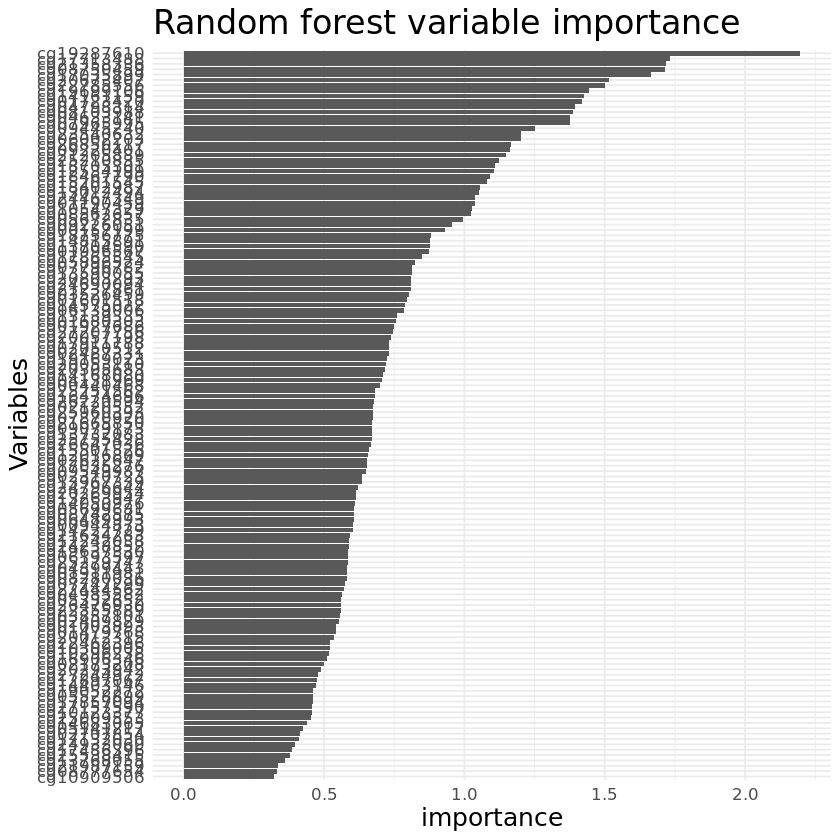

In [9]:
### Perform feature selection using importance
percentile_cutoff = 0.90
## ERA vs CCP+
rfClassModel_optMod = rfClassModel_eravccpP_optMod

# Get variable importance, and turn into a data frame
var_imp = varImp(rfClassModel_optMod, scale=FALSE)$importance
var_imp_df = data.frame(variables=row.names(var_imp), importance=var_imp$Overall)

# Create a plot of variable importance
var_imp_df %>%
        arrange(importance) %>%                                                   # Sort the data by importance
        ggplot(aes(x=reorder(variables, importance), y=importance)) +             # Create a ggplot object for aesthetic
        geom_bar(stat='identity') +                                               # Plot the bar graph
        coord_flip() +                                                            # Flip the graph to make a horizontal bar plot
        xlab('Variables') +                                                       # Add x-axis label
        labs(title='Random forest variable importance') +                         # Add a title
        theme_minimal() +                                                         # Some layout for the plot
        theme(axis.text = element_text(size = 10), 
              axis.title = element_text(size = 15), 
              plot.title = element_text(size = 20), 
              )

# select key variables
#importance_cutoff = mean(var_imp_df$importance)
importance_cutoff = quantile(var_imp_df$importance, probs = percentile_cutoff)

selVar_imp_df = var_imp_df[var_imp_df$importance > importance_cutoff, ]
selVar_imp_vector = selVar_imp_df$variables

selVar_eravccpP_M_analysis_df = M_analysis_df[selVar_imp_vector, ]

print("ERA vs CCP+")
head(selVar_eravccpP_M_analysis_df)
dim(selVar_eravccpP_M_analysis_df)


## ERA vs CCP-
rfClassModel_optMod = rfClassModel_eravccpM_optMod

# Get variable importance, and turn into a data frame
var_imp = varImp(rfClassModel_optMod, scale=FALSE)$importance
var_imp_df = data.frame(variables=row.names(var_imp), importance=var_imp$Overall)

# Create a plot of variable importance
var_imp_df %>%
        arrange(importance) %>%                                                   # Sort the data by importance
        ggplot(aes(x=reorder(variables, importance), y=importance)) +             # Create a ggplot object for aesthetic
        geom_bar(stat='identity') +                                               # Plot the bar graph
        coord_flip() +                                                            # Flip the graph to make a horizontal bar plot
        xlab('Variables') +                                                       # Add x-axis label
        labs(title='Random forest variable importance') +                         # Add a title
        theme_minimal() +                                                         # Some layout for the plot
        theme(axis.text = element_text(size = 10), 
              axis.title = element_text(size = 15), 
              plot.title = element_text(size = 20), 
              )

# select key variables
#importance_cutoff = mean(var_imp_df$importance)
importance_cutoff = quantile(var_imp_df$importance, probs = percentile_cutoff)

selVar_imp_df = var_imp_df[var_imp_df$importance > importance_cutoff, ]
selVar_imp_vector = selVar_imp_df$variables

selVar_eravccpM_M_analysis_df = M_analysis_df[selVar_imp_vector, ]

print("ERA vs CCP-")
head(selVar_eravccpM_M_analysis_df)
dim(selVar_eravccpM_M_analysis_df)


## CCP+ vs CCP-
rfClassModel_optMod = rfClassModel_ccpPvccpM_optMod

# Get variable importance, and turn into a data frame
var_imp = varImp(rfClassModel_optMod, scale=FALSE)$importance
var_imp_df = data.frame(variables=row.names(var_imp), importance=var_imp$Overall)

# Create a plot of variable importance
var_imp_df %>%
        arrange(importance) %>%                                                   # Sort the data by importance
        ggplot(aes(x=reorder(variables, importance), y=importance)) +             # Create a ggplot object for aesthetic
        geom_bar(stat='identity') +                                               # Plot the bar graph
        coord_flip() +                                                            # Flip the graph to make a horizontal bar plot
        xlab('Variables') +                                                       # Add x-axis label
        labs(title='Random forest variable importance') +                         # Add a title
        theme_minimal() +                                                         # Some layout for the plot
        theme(axis.text = element_text(size = 10), 
              axis.title = element_text(size = 15), 
              plot.title = element_text(size = 20), 
              )

# select key variables
#importance_cutoff = mean(var_imp_df$importance)
importance_cutoff = quantile(var_imp_df$importance, probs = percentile_cutoff)

selVar_imp_df = var_imp_df[var_imp_df$importance > importance_cutoff, ]
selVar_imp_vector = selVar_imp_df$variables

selVar_ccpPvccpM_M_analysis_df = M_analysis_df[selVar_imp_vector, ]

print("CCP+ vs CCP-")
head(selVar_ccpPvccpM_M_analysis_df)
dim(selVar_ccpPvccpM_M_analysis_df)


## Combined
print("combined data")
selVar_comb_imp_vector = Reduce(union, list(rownames(selVar_eravccpP_M_analysis_df),
                                            rownames(selVar_eravccpM_M_analysis_df),
                                            rownames(selVar_ccpPvccpM_M_analysis_df)))

selVar_comb_M_analysis_df = M_analysis_df[selVar_comb_imp_vector, ]
head(selVar_comb_M_analysis_df)
dim(selVar_comb_M_analysis_df)

In [10]:
### PCA
# define plot matrix
plot_mtrx = as.matrix(selVar_comb_M_analysis_df)

# create principal components
set.seed(12)
pca1 = prcomp_irlba(plot_mtrx, n=3, center = TRUE, scale=TRUE)

a<-pca1$rotation[,1]
b<-pca1$rotation[,2]
c<-pca1$rotation[,3]

var_pc1<-paste(round(summary(pca1)[[7]][2,1],4)*100,"%",sep="")
var_pc2<-paste(round(summary(pca1)[[7]][2,2],4)*100,"%",sep="")
var_pc3<-paste(round(summary(pca1)[[7]][2,3],4)*100,"%",sep="")

xname<-paste("PC1(",var_pc1,")",sep="")
yname<-paste("PC2(",var_pc2,")",sep="")
zname<-paste("PC3(",var_pc3,")",sep="")

# define color universe
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

# create labels
id = colnames(plot_mtrx)
idSplit = strsplit(id, split = "_", fixed = T)

lab_id = sapply(idSplit, `[`, 2)
patient_id = sapply(idSplit, `[`, 1)

cell_type = as.vector(unlist(lapply(idSplit, function(x) x[length(x) -1])))
RA_status = as.vector(unlist(lapply(idSplit, function(x) x[length(x)])))


[1] "CCPneg" "CCPpos" "ERA"

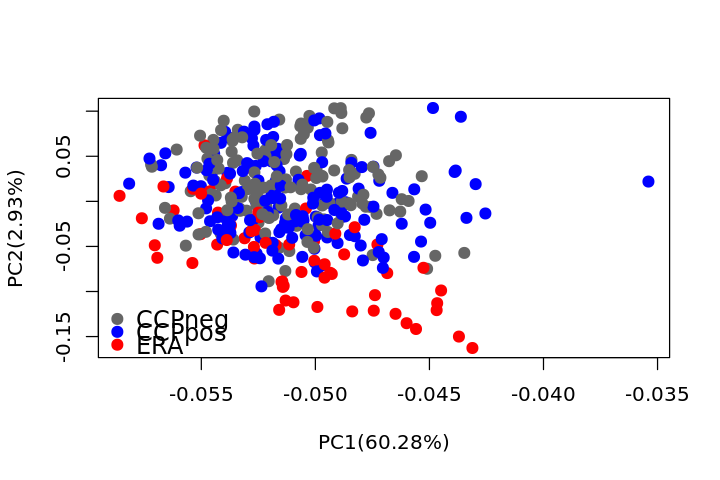

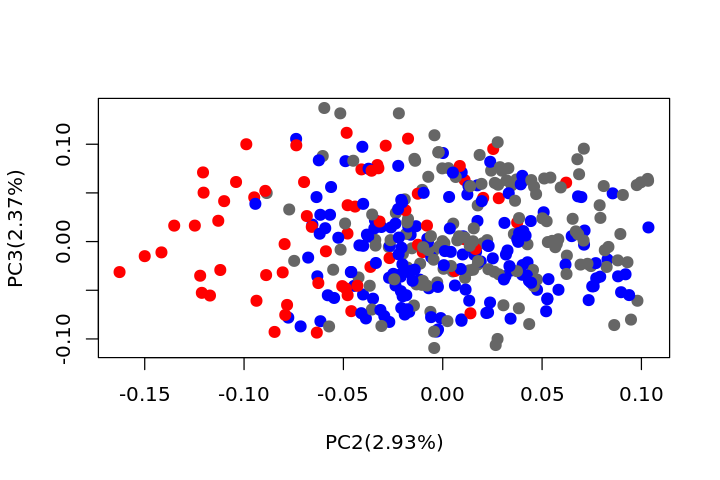

png 
  2

png 
  2

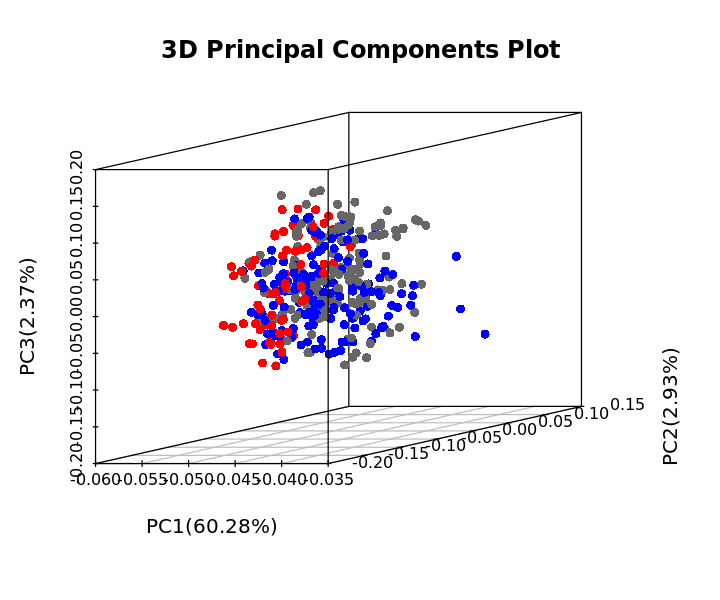

In [16]:
# Plot chart
plotColor_driver = RA_status

plotColors = c("grey40", "blue", "red")
names(plotColors) = levels(factor(plotColor_driver))
colors = unname(plotColors[plotColor_driver])

shapes = rep(19, length(plotColor_driver))

dd = as.character(id)
names(colors) = unique(dd)
names(shapes) = unique(dd)

levels(factor(plotColor_driver))

# PC1 v PC2
options(repr.plot.width=6, repr.plot.height=4)
plot(a, b, col = colors[dd], pch = shapes[dd], xlab = xname, ylab = yname, cex = 1.2)
#pointLabel(a, b, labels = plotColor_driver, cex = 1.2)
legend("bottomleft", legend = levels(factor(plotColor_driver)), col = plotColors, border = "black", bty = "n", pch = shapes, cex = 1.2)

# PC2 v PC3
options(repr.plot.width=6, repr.plot.height=4)
plot(b, c, col = colors[dd], pch = shapes[dd], xlab = yname, ylab = zname, cex = 1.2)
#pointLabel(b, c, labels = plotColor_driver, cex = 1.2)
#legend("bottomleft", legend = levels(factor(plotColor_driver)), col = plotColors, border = "black", bty = "n", pch = shapes, cex = 1.2)

# 3D version
options(repr.plot.width=6, repr.plot.height=5)
scatterplot3d(a, b, c, pch = 16, color=colors, main="3D Principal Components Plot", xlab = xname, ylab = yname, zlab = zname, angle=20)

setwd(rfClass_output_dir)
png(paste0(rfClass_output_dir, "/rfClass_3Dpca_plot.png"), width = 6, height = 5, res = 1200, units = "in")
scatterplot3d(a, b, c, pch = 16, color=colors, main="3D Principal Components Plot", xlab = xname, ylab = yname, zlab = zname, angle=20)
dev.off()

setwd(rfClass_output_dir)
pdf(paste0(rfClass_output_dir, "/rfClass_3Dpca_plot.pdf"), width = 6, height = 5)
scatterplot3d(a, b, c, pch = 16, color=colors, xlab = xname, ylab = yname, zlab = zname, angle=20)
dev.off()

In [17]:
# output source data
figureSourceData_df = data.frame("PC1" = a,
                                 "PC2" = b,
                                 "PC3" = c,
                                 "color" = colors)
rownames(figureSourceData_df) = names(colors)

setwd(rfClass_output_dir)
write.csv(figureSourceData_df,"rfClass_3Dpca_data.csv", row.names=TRUE)

In [18]:
### create dataframe of DML, Delta Beta, q-val beta, and possible DMG and export
rfClass_beta_analysis_df = beta_analysis_df[selVar_comb_imp_vector, ]
dim(rfClass_beta_analysis_df)

## create vectors
# samples
ccpP_sample_vector = grep("CCPpos", colnames(rfClass_beta_analysis_df), value=TRUE)
ccpM_sample_vector = grep("CCPneg", colnames(rfClass_beta_analysis_df), value=TRUE)
era_sample_vector = grep("ERA", colnames(rfClass_beta_analysis_df), value=TRUE)

# delta beta
bDif_ccpPvccpM_vector = rowMeans(rfClass_beta_analysis_df[, c(ccpP_sample_vector)]) - rowMeans(rfClass_beta_analysis_df[, c(ccpM_sample_vector)])
bDif_ccpMvera_vector = rowMeans(rfClass_beta_analysis_df[, c(ccpM_sample_vector)]) - rowMeans(rfClass_beta_analysis_df[, c(era_sample_vector)])
bDif_ccpPvera_vector = rowMeans(rfClass_beta_analysis_df[, c(ccpP_sample_vector)]) - rowMeans(rfClass_beta_analysis_df[, c(era_sample_vector)])

# P-value
pVal_ccpPvccpM_vector = apply(rfClass_beta_analysis_df, 1, function (x) t.test(x[c(ccpP_sample_vector)], x[c(ccpM_sample_vector)], alternative = "two.sided", paired = FALSE, var.equal = FALSE)$p.value)
pVal_ccpMvera_vector = apply(rfClass_beta_analysis_df, 1, function (x) t.test(x[c(ccpM_sample_vector)], x[c(era_sample_vector)], alternative = "two.sided", paired = FALSE, var.equal = FALSE)$p.value)
pVal_ccpPvera_vector = apply(rfClass_beta_analysis_df, 1, function (x) t.test(x[c(ccpP_sample_vector)], x[c(era_sample_vector)], alternative = "two.sided", paired = FALSE, var.equal = FALSE)$p.value)

# adjusted P-Value
aPval_ccpPvccpM_vector = p.adjust(pVal_ccpPvccpM_vector, method = "BH", n = length(pVal_ccpPvccpM_vector))
aPval_ccpMvera_vector = p.adjust(pVal_ccpMvera_vector, method = "BH", n = length(pVal_ccpMvera_vector))
aPval_ccpPvera_vector = p.adjust(pVal_ccpPvera_vector, method = "BH", n = length(pVal_ccpPvera_vector))

length(aPval_ccpPvera_vector)
                             
# DMGs
# Create annotation data and define promoter regions and gene body regions
# create annotation dataframe
anno_data = getAnnotation(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)

# create gRanges object of defined promoter regions
tss_gr = getHumanTSS()

promoter_gr = GRanges(seqnames=paste0("chr", seqnames(tss_gr)),
                      ranges=IRanges(start=start(ranges(tss_gr))-2500, end=start(ranges(tss_gr))+500),
                      strand=strand(tss_gr),
                      names=tss_gr$gene)

promoter_gr = sortSeqlevels(promoter_gr)
promoter_gr = sort(promoter_gr)

# create gRanges objects of defined gene body
mart = useDataset("hsapiens_gene_ensembl", useMart(biomart="ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org", path="/biomart/martservice", dataset="hsapiens_gene_ensembl"))
geneBodyCoords_df = getBM(attributes=c("hgnc_symbol", "chromosome_name", "strand", "start_position", "end_position"), mart = mart)

geneBodyCoords_filtered_df = geneBodyCoords_df[(geneBodyCoords_df$chromosome_name %in% seq(1:23)),]
geneBodyCoords_filtered_df = geneBodyCoords_filtered_df[(geneBodyCoords_filtered_df$hgnc_symbol %in% promoter_gr$names),]

class(geneBodyCoords_filtered_df$strand) = "character"
geneBodyCoords_filtered_df[geneBodyCoords_filtered_df$strand == "-1", "strand"] = "-"
geneBodyCoords_filtered_df[geneBodyCoords_filtered_df$strand == "1", "strand"] = "+"


geneBody_gr = GRanges(seqnames=paste0("chr", geneBodyCoords_filtered_df$chromosome_name), 
                      ranges=IRanges(start=geneBodyCoords_filtered_df$start_position, end=geneBodyCoords_filtered_df$end_position),
                      strand=geneBodyCoords_filtered_df$strand,
                      names=geneBodyCoords_filtered_df$hgnc_symbol)
                      
geneBody_gr = sortSeqlevels(geneBody_gr)
geneBody_gr = sort(geneBody_gr)

# create gRanges objects of defined gene body + promoter region
combinedRegion_gr = append(promoter_gr, geneBody_gr)

# create vector of DMGs
# create annotation df
selVar_imp_an = anno_data[selVar_comb_imp_vector,]
# create gRanges object
selVar_imp_gr = GRanges(seqnames=selVar_imp_an$chr,
                ranges=IRanges(start=selVar_imp_an$pos, end=selVar_imp_an$pos),
                strand=selVar_imp_an$strand,
                names=selVar_imp_an$Name)
# take overlap by comparing coordinates against promoter / gene body gRanges object
selVar_imp_overlap_gr = subsetByOverlaps(combinedRegion_gr, selVar_imp_gr)

# output of findOverlaps is a 'hits' object indicating which of the query and subject overlap
hits = findOverlaps(combinedRegion_gr, selVar_imp_gr)

# add the DMGs from hits to the selVar_imp_gr object
mcols(selVar_imp_gr)$DMG = NA
mcols(selVar_imp_gr)$DMG[subjectHits(hits)] = mcols(combinedRegion_gr)$names[queryHits(hits)]


[1] 181 381

[1] 181

Warning message:
“Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://"”


In [19]:
## create dataframe
rfClass_output_df = data.frame(DML=selVar_comb_imp_vector,
                               ccpPvccpM_bDiff=bDif_ccpPvccpM_vector,
                               ccpPvccpM_aPval=aPval_ccpPvccpM_vector,
                               ccpMvera_bDiff=bDif_ccpMvera_vector,
                               ccpMvera_aPval=aPval_ccpMvera_vector,
                               ccpPvera_bDiff=bDif_ccpPvera_vector,
                               ccpPvera_aPval=aPval_ccpPvera_vector,
                               DMG=selVar_imp_gr$DMG
                               )


# output
write.csv(rfClass_output_df, paste0(rfClass_output_dir, "/rfClass_dmlDmgData_df.csv"))

In [20]:
## Export data for analysis
rfClass_data_df = beta_analysis_df[selVar_comb_imp_vector,]
write.csv(rfClass_data_df, paste0(rfClass_output_dir, "/rfClass_data_df.csv"))

In [21]:
sample_vector = colnames(rfClass_data_df)
head(sample_vector)
bCell_all_vector = grep(paste(c("_B_"),collapse="|"), sample_vector, value = TRUE)
head(bCell_all_vector)

[1] "p41_ls39_B_CCPpos" "p38_ls29_B_CCPneg" "p11_ls4_B_CCPneg" 
[4] "p60_ls53_B_ERA"    "p24_ls27_B_CCPneg" "p4_ls9_B_CCPpos"

[1] "p41_ls39_B_CCPpos" "p38_ls29_B_CCPneg" "p11_ls4_B_CCPneg" 
[4] "p60_ls53_B_ERA"    "p24_ls27_B_CCPneg" "p4_ls9_B_CCPpos"

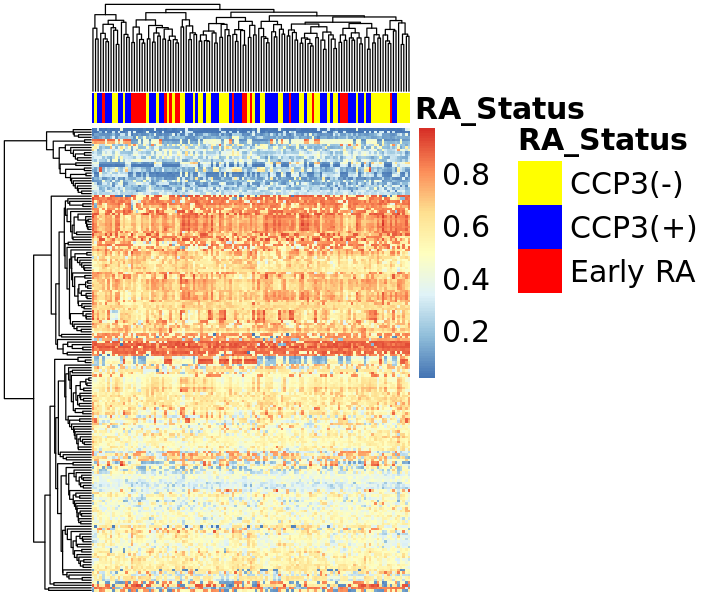

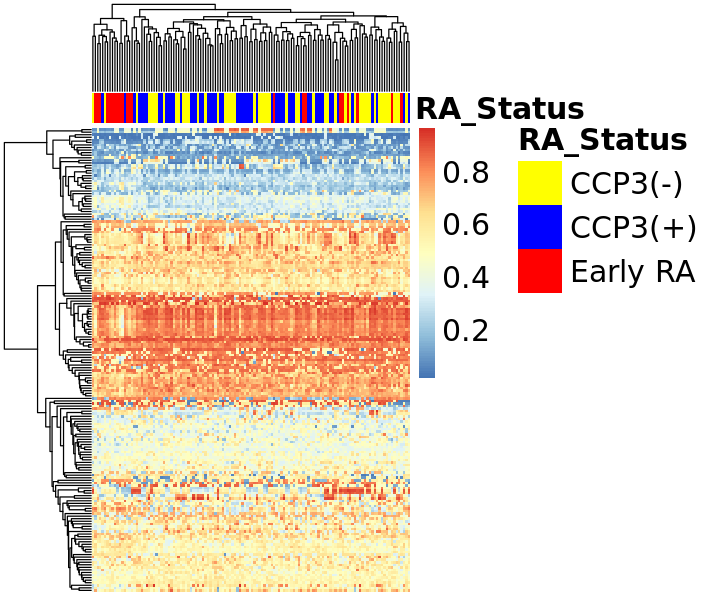

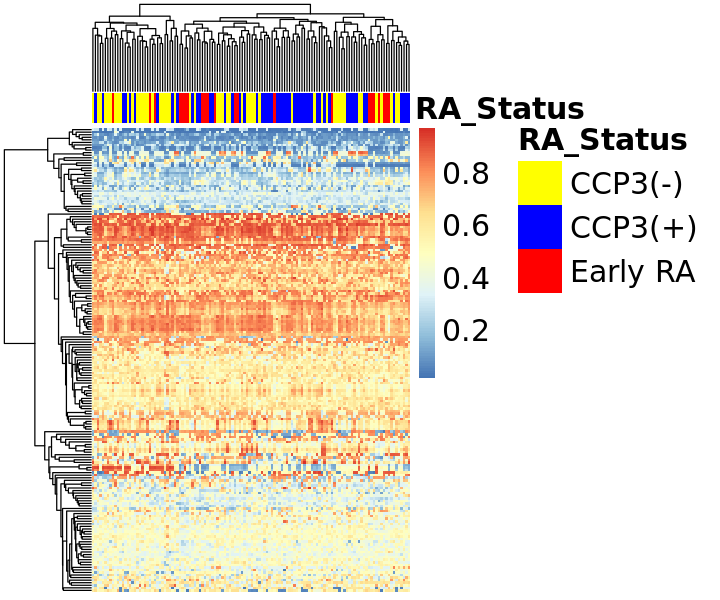

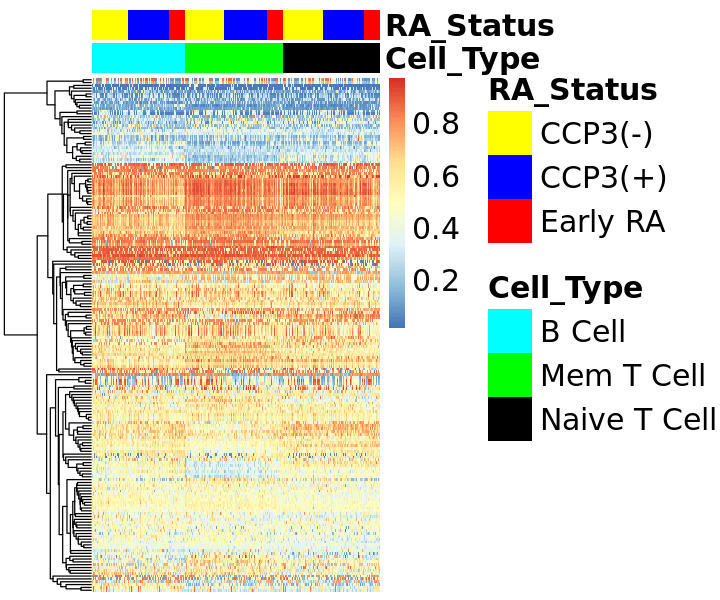

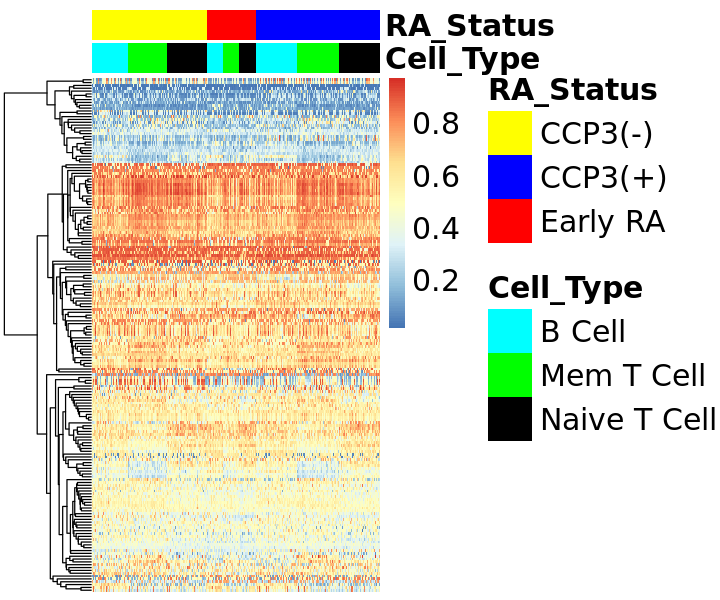

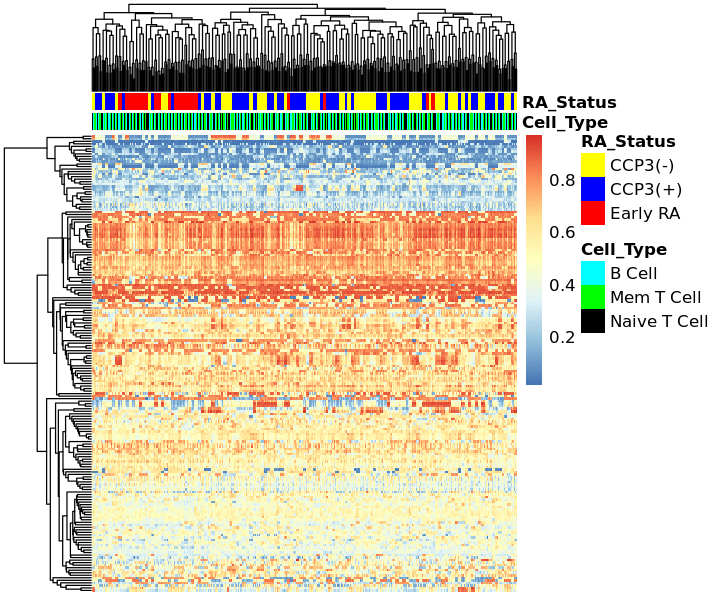

In [28]:
### Create heatmaps
rfClass_data_df = rfClass_data_df

## generate input and metadata dfs
# generate vectors of each group's selected loci

# generate vectors of each group's samples
sample_vector = colnames(rfClass_data_df)
# if limiting to cohort 2...
#sample_vector = grep(paste(c("batch1"),collapse="|"), sample_vector, value = TRUE, invert = TRUE)

bCell_all_vector = grep(paste(c("_B_"),collapse="|"), sample_vector, value = TRUE)
bCell_ccpM_vector = grep(paste(c("_CCPneg"),collapse="|"), bCell_all_vector, value = TRUE)
bCell_ccpP_vector = grep(paste(c("_CCPpos"),collapse="|"), bCell_all_vector, value = TRUE)
bCell_era_vector = grep(paste(c("_ERA"),collapse="|"), bCell_all_vector, value = TRUE)

tMem_all_vector = grep(paste(c("_Tmem"),collapse="|"), sample_vector, value = TRUE)
tMem_ccpM_vector = grep(paste(c("_CCPneg"),collapse="|"), tMem_all_vector, value = TRUE)
tMem_ccpP_vector = grep(paste(c("_CCPpos"),collapse="|"), tMem_all_vector, value = TRUE)
tMem_era_vector = grep(paste(c("_ERA"),collapse="|"), tMem_all_vector, value = TRUE)

tNai_all_vector = grep(paste(c("_Tnai"),collapse="|"), sample_vector, value = TRUE)
tNai_ccpM_vector = grep(paste(c("_CCPneg"),collapse="|"), tNai_all_vector, value = TRUE)
tNai_ccpP_vector = grep(paste(c("_CCPpos"),collapse="|"), tNai_all_vector, value = TRUE)
tNai_era_vector = grep(paste(c("_ERA"),collapse="|"), tNai_all_vector, value = TRUE)

## create input df
# create input dfs for each
bCell_input_df = rfClass_data_df[, c(bCell_ccpM_vector, bCell_ccpP_vector, bCell_era_vector)]
tMem_input_df = rfClass_data_df[, c(tMem_ccpM_vector, tMem_ccpP_vector, tMem_era_vector)]
tNai_input_df = rfClass_data_df[, c(tNai_ccpM_vector, tNai_ccpP_vector, tNai_era_vector)]

all_cellType_input_df = rfClass_data_df[, c(bCell_ccpM_vector, bCell_ccpP_vector, bCell_era_vector,
                                            tMem_ccpM_vector, tMem_ccpP_vector, tMem_era_vector,
                                            tNai_ccpM_vector, tNai_ccpP_vector, tNai_era_vector)]

all_RAstatus_input_df = rfClass_data_df[, c(bCell_ccpM_vector, tMem_ccpM_vector, tNai_ccpM_vector, 
                                            bCell_era_vector, tMem_era_vector, tNai_era_vector,
                                            bCell_ccpP_vector, tMem_ccpP_vector, tNai_ccpP_vector)]

## generate annotations for rows and columns
# bCell
bCell_cellType_vector = sapply(strsplit(colnames(bCell_input_df), "_"), '[', 3)
bCell_RAstatus_vector = sapply(strsplit(colnames(bCell_input_df), "_"), '[', 4)

bCell_annotation_df = data.frame(Cell_Type =  c("B Cell", "Mem T Cell", "Naive T Cell", bCell_cellType_vector)[match(bCell_cellType_vector, c("B", "Tmem", "Tnai", bCell_cellType_vector))],
                               RA_Status = c("CCP3(-)", "CCP3(+)", "Early RA", bCell_RAstatus_vector)[match(bCell_RAstatus_vector, c("CCPneg", "CCPpos", "ERA", bCell_RAstatus_vector))])
rownames(bCell_annotation_df) = colnames(bCell_input_df)

# tMem
tMem_cellType_vector = sapply(strsplit(colnames(tMem_input_df), "_"), '[', 3)
tMem_RAstatus_vector = sapply(strsplit(colnames(tMem_input_df), "_"), '[', 4)

tMem_annotation_df = data.frame(Cell_Type =  c("B Cell", "Mem T Cell", "Naive T Cell", tMem_cellType_vector)[match(tMem_cellType_vector, c("B", "Tmem", "Tnai", tMem_cellType_vector))],
                               RA_Status = c("CCP3(-)", "CCP3(+)", "Early RA", tMem_RAstatus_vector)[match(tMem_RAstatus_vector, c("CCPneg", "CCPpos", "ERA", tMem_RAstatus_vector))])
rownames(tMem_annotation_df) = colnames(tMem_input_df)

# tNai
tNai_cellType_vector = sapply(strsplit(colnames(tNai_input_df), "_"), '[', 3)
tNai_RAstatus_vector = sapply(strsplit(colnames(tNai_input_df), "_"), '[', 4)

tNai_annotation_df = data.frame(Cell_Type =  c("B Cell", "Mem T Cell", "Naive T Cell", tNai_cellType_vector)[match(tNai_cellType_vector, c("B", "Tmem", "Tnai", tNai_cellType_vector))],
                               RA_Status = c("CCP3(-)", "CCP3(+)", "Early RA", tNai_RAstatus_vector)[match(tNai_RAstatus_vector, c("CCPneg", "CCPpos", "ERA", tNai_RAstatus_vector))])
rownames(tNai_annotation_df) = colnames(tNai_input_df)

# all
all_cellType_vector = sapply(strsplit(colnames(all_cellType_input_df), "_"), '[', 3)
all_RAstatus_vector = sapply(strsplit(colnames(all_cellType_input_df), "_"), '[', 4)

all_annotation_df = data.frame(Cell_Type =  c("B Cell", "Mem T Cell", "Naive T Cell", all_cellType_vector)[match(all_cellType_vector, c("B", "Tmem", "Tnai", all_cellType_vector))],
                               RA_Status = c("CCP3(-)", "CCP3(+)", "Early RA", all_RAstatus_vector)[match(all_RAstatus_vector, c("CCPneg", "CCPpos", "ERA", all_RAstatus_vector))])
rownames(all_annotation_df) = colnames(all_cellType_input_df)

ann_colors = list(Cell_Type = c("B Cell"="cyan", "Mem T Cell"="green", "Naive T Cell"="black"),
                  RA_Status = c("CCP3(-)"="yellow", "CCP3(+)"="blue", "Early RA"="red"))

# create heatmaps
bCell_dml_hm = pheatmap(bCell_input_df, annotation_col = bCell_annotation_df[,"RA_Status", drop = FALSE], 
                  cluster_cols = TRUE,
                  annotation_colors = ann_colors,
                  show_rownames = FALSE, show_colnames = FALSE,
                  fontsize = 18)

tMem_dml_hm = pheatmap(tMem_input_df, annotation_col = tMem_annotation_df[,"RA_Status", drop = FALSE], 
                        cluster_cols = TRUE,
                        annotation_colors = ann_colors,
                        show_rownames = FALSE, show_colnames = FALSE,
                        fontsize = 18)

tNai_dml_hm = pheatmap(tNai_input_df, annotation_col = tNai_annotation_df[,"RA_Status", drop = FALSE], 
                        cluster_cols = TRUE,
                        annotation_colors = ann_colors,
                        show_rownames = FALSE, show_colnames = FALSE,
                        fontsize = 18)

all_cellType_dml_hm = pheatmap(all_cellType_input_df, annotation_col = all_annotation_df, 
                               cluster_cols = FALSE,
                               annotation_colors = ann_colors, show_rownames = FALSE, show_colnames = FALSE, fontsize = 18)

all_RAstatus_dml_hm = pheatmap(all_RAstatus_input_df, annotation_col = all_annotation_df, 
                               cluster_cols = FALSE,
                               annotation_colors = ann_colors, show_rownames = FALSE, show_colnames = FALSE, fontsize = 18)

all_clustered_dml_hm = pheatmap(all_cellType_input_df, annotation_col = all_annotation_df, 
                               cluster_cols = TRUE,
                               annotation_colors = ann_colors, show_rownames = FALSE, show_colnames = FALSE, fontsize = 10)



In [31]:
# output charts
png(paste0(rfClass_output_dir, "/rfClass_bCell_hm.png"), width = 840, height = 300, units = "px")
bCell_dml_hm
dev.off()

pdf(paste0(rfClass_output_dir, "/rfClass_bCell_hm.pdf"), width = 7, height = 2.5)
bCell_dml_hm
dev.off()

png(paste0(rfClass_output_dir, "/rfClass_tMem_hm.png"), width = 840, height = 300, units = "px")
tMem_dml_hm
dev.off()

png(paste0(rfClass_output_dir, "/rfClass_tMem_hm.pdf"), width = 7, height = 2.5)
tMem_dml_hm
dev.off()

png(paste0(rfClass_output_dir, "/rfClass_tNai_hm.png"), width = 840, height = 300, units = "px")
tNai_dml_hm
dev.off()

pdf(paste0(rfClass_output_dir, "/rfClass_tNai_hm.pdf"), width = 7, height = 2.5)
tNai_dml_hm
dev.off()

png(paste0(rfClass_output_dir, "/rfClass_allClustered_hm.png"), width = 840, height = 600, units = "px")
all_clustered_dml_hm
dev.off()

pdf(paste0(rfClass_output_dir, "/rfClass_allClustered_hm.pdf"), width = 8, height = 6)
all_clustered_dml_hm
dev.off()


# output data
setwd(rfClass_output_dir)
write.csv(bCell_input_df,"rfClass_bCell_data.csv", row.names=TRUE)
write.csv(bCell_annotation_df,"rfClass_bCell_annotation.csv", row.names=TRUE)

write.csv(tMem_input_df,"rfClass_tMem_data.csv", row.names=TRUE)
write.csv(tMem_annotation_df,"rfClass_tMem_annotation.csv", row.names=TRUE)

write.csv(tNai_input_df,"rfClass_tNai_data.csv", row.names=TRUE)
write.csv(tNai_annotation_df,"rfClass_tNai_annotation.csv", row.names=TRUE)

write.csv(all_cellType_input_df,"rfClass_allClustered_data.csv", row.names=TRUE)
write.csv(all_annotation_df,"rfClass_allClustered_annotation.csv", row.names=TRUE)


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [24]:
### Quantify clustering effectiveness using rand index
table(cutree(all_clustered_dml_hm$tree_col, k = 3)[grep("ERA", names(cutree(all_clustered_dml_hm$tree_col, k = 3)), value = TRUE)])
table(cutree(all_clustered_dml_hm$tree_col, k = 3)[grep("CCPpos", names(cutree(all_clustered_dml_hm$tree_col, k = 3)), value = TRUE)])
table(cutree(all_clustered_dml_hm$tree_col, k = 3)[grep("CCPneg", names(cutree(all_clustered_dml_hm$tree_col, k = 3)), value = TRUE)])


 1  2  3 
53  9  3 


 1  2  3 
33 94 37 


  1   2   3 
 21 100  31 

In [25]:
### Sink all stats to dataLog
sink(dataLog_fp)
cat(paste0("Pooled samples from cohorts 1 and 2 ", 
       "(anti-CCP3(-) Controls = ", length(unique(sapply(strsplit(grep(paste(c("CCPneg"),collapse="|"), colnames(M_analysis_df), value = TRUE), "_"), '[', 1))), " participants, ", 
       length(sapply(strsplit(grep(paste(c("CCPneg"),collapse="|"), colnames(M_analysis_df), value = TRUE), "_"), '[', 1)), " samples; ", 
       "At-Risk = ", length(unique(sapply(strsplit(grep(paste(c("CCPpos"),collapse="|"), colnames(M_analysis_df), value = TRUE), "_"), '[', 1))), " participants, ",
       length(sapply(strsplit(grep(paste(c("CCPpos"),collapse="|"), colnames(M_analysis_df), value = TRUE), "_"), '[', 1)), " samples; and ", 
       "Early RA = ", length(unique(sapply(strsplit(grep(paste(c("ERA"),collapse="|"), colnames(M_analysis_df), value = TRUE), "_"), '[', 1))), " participants, ", 
       length(sapply(strsplit(grep(paste(c("ERA"),collapse="|"), colnames(M_analysis_df), value = TRUE), "_"), '[', 1)), " samples) were first split into training and test data sets."))
cat("\n")

cat(paste0("After feature selection, the models achieved accuracies of ", 
       eravccpP_accuracy, "%, ", 
       eravccpM_accuracy, "% and ",
       ccpPvccpM_accuracy, "% on the test data when discriminating between Early RA vs At-Risk, Early RA vs anti-CCP3(-) Controls and At-Risk vs anti-CCP3(-) Controls, respectively."))

sink()

Pooled samples from cohorts 1 and 2 (anti-CCP3(-) Controls = 52 participants, 152 samples; At-Risk = 56 participants, 164 samples; and Early RA = 22 participants, 65 samples) were first split into training and test data sets.
After feature selection, the models achieved accuracies of 89.7058823529412%, 78.125% and 96.8085106382979% on the test data when discriminating between Early RA vs At-Risk, Early RA vs anti-CCP3(-) Controls and At-Risk vs anti-CCP3(-) Controls, respectively.